In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare

%watermark -a 'Ethen' -d -t -v -p numpy,scipy,pandas,matplotlib,statsmodels

Ethen 2017-08-07 13:55:37 

CPython 3.5.2
IPython 5.4.1

numpy 1.13.1
scipy 0.19.1
pandas 0.20.2
matplotlib 2.0.2
statsmodels 0.8.0


In [3]:
# setup the look and feel of the notebook
plt.rcParams['figure.figsize'] = 8, 6
sns.set_context('notebook', font_scale = 1.5, 
                rc = {'lines.linewidth': 2.5})
sns.set_style('whitegrid')
sns.set_palette('deep')

# Create a couple of colors to use throughout the notebook
red = sns.xkcd_rgb['vermillion']
blue = sns.xkcd_rgb['dark sky blue']

# Frequentist A/B testing

The warming-up section is a quick review of the concept of p-value, feel free to skip it if you're already acquainted with the concept.

## Warming-up

Lets starts off with a motivating example that asks the question "If you toss a coin 30 times and see 22 heads, is it a fair coin?"

We all know that a fair coin should come up heads roughly 15 out of 30 tosses, give or take, so it does seem unlikely to see so many heads. However, the skeptic might argue that even a fair coin could show 22 heads in 30 tosses from time-to-time. This could just be a chance event. So, the question would then be "how can you determine if we're tossing a fair coin?"

Let's start by first considering the probability of a single coin flip coming up heads and work our way up to 22 out of 30.

\begin{align}
P(H) = \frac{1}{2}
\end{align}

As our equation shows, the probability of a single coin toss turning up heads is exactly 50% since there is an equal chance of either heads or tails turning up. Taking this one step further, to determine the probability of getting 2 heads in a row with 2 coin tosses, we would need to multiply the probability of getting heads by the probability of getting heads again since the two events are independent of one another.

\begin{align}
P(HH) = P(H) \cdot P(H) = P(H)^2 = \left(\frac{1}{2}\right)^2 = \frac{1}{4}
\end{align}

Let's now take a look at a slightly different scenario and calculate the probability of getting 2 heads and 1 tails with 3 coin tosses. To get the actual probability of tossing 2 heads and 1 tails we will have to add the probabilities for all of the possible permutations, of which there are exactly three: HHT, HTH, and THH.

\begin{align}
P(2H,1T) = P(HHT) + P(HTH) + P(THH) = \frac{1}{8} + \frac{1}{8} + \frac{1}{8} = \frac{3}{8}
\end{align}

Another way we could do this is to use the binomial distribution:

\begin{align}
P(N_H,N_T) = \binom{n}{k} p^{k} \left( 1 - p \right)^{n - k}
\end{align}

Where 

- $n$ is number of coin flips
- $p$ is the probability of getting heads on each flip

The $\binom{n}{k}$ tells us how many ways are there to get $k$ heads our of $n$ total number of coin flips?" and the $p^k(1-p)^{n-k}$ answers the question "how likely is any given $k$ heads and $n-k$ tails?", multiply them together and we get the probability of getting exactly $k$ heads.

Now that we understand the classic method, let's use it to test whether we are actually tossing a fair coin.

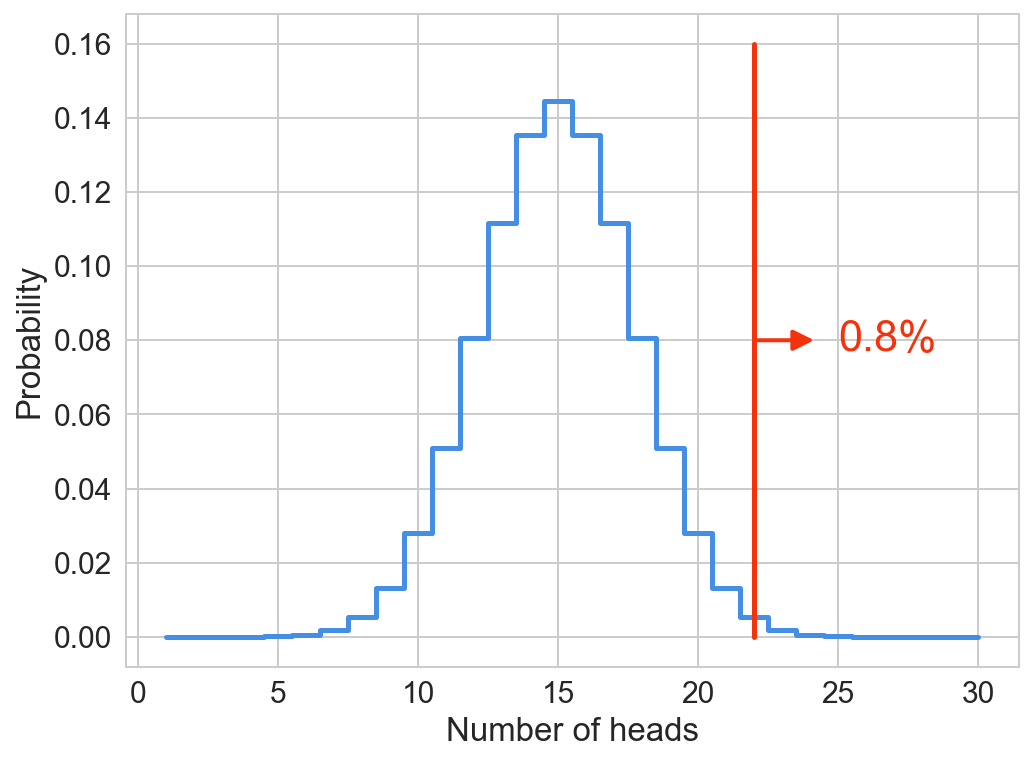

In [4]:
# Calculate the probability for every possible outcome
# of tossing a fair coin 30 k_range

k_range = range(1, 31)  # number of heads appearing
n = 30  # number of k_range tossing the coin
p = 0.5  # probability of coin appearing up as head

probabilities = stats.binom(n = n, p = p).pmf(k = k_range)

# Plot the probability distribution using the probabilities list 
# we created above.
plt.step(k_range, probabilities, where = 'mid', color = blue)
plt.xlabel('Number of heads')
plt.ylabel('Probability')
plt.plot((22, 22), (0, 0.1599), color = red)
plt.annotate('0.8%', xytext = (25, 0.08), xy = (22, 0.08), 
             va = 'center', color = red, size = 'large',
             arrowprops = {'arrowstyle': '<|-', 'lw': 2,
                           'color': red, 'shrinkA': 10})
plt.show()

The visualization above shows the probability distribution for flipping a fair coin 30 times. Using this visualization we can now determine the probability of getting, say for example, 12 heads in 30 flips, which looks to be about 8%. Notice that we've labeled our example of 22 heads as 0.8%. If we look at the probability of flipping exactly 22 heads, it looks likes to be a little less than 0.8%, in fact if we calculate it using the function from above, we get 0.5%.

In [5]:
prob = stats.binom(n = n, p = p).pmf(k = 22)
print('Probability of flipping 22 heads: {:0.1f}%'.format(prob * 100))

Probability of flipping 22 heads: 0.5%


So, then why do we have 0.8% labeled in our probability distribution above? Well, that's because we are showing the probability of getting **at least** 22 heads, which is also known as the **p-value**.


###  Hypothesis Testing

Let's pull back from our example and discuss a little bit about hypothesis testing. In standard frequentist statistic's hypothesis testing, we start with a null hypothesis that we usually call $H_0$ (pronouced as H naught), which represents our status quo. On the other hand, we also have an alternative hypothesis our $H_1$ that represents the question that we wish to answer, i.e. what we’re testing for.

After setting up our null and alternative hypothesis, we conduct a hypothesis test under the assumption that the null hypothesis is true. If the test results suggest that the data do not provide convincing evidence for the alternative hypothesis, we stick with the null hypothesis. If they do, then we reject the null hypothesis in favor of the alternative.

Frequentist statistic's hypothesis testing uses a p-value to weigh the strength of the evidence (what the data is telling you about the population). p-value is defined as **the probability of obtaining the observed or more extreme outcome, given that the null hypothesis is true (not the probability that the alternative hypthesis is true)**. It is a number between 0 and 1 and interpreted in the following way:

- A small p-value (typically <= 0.05, 0.05 is a commonly used threshold, the threshold is often denoted as $\alpha$) indicates strong evidence against the null hypothesis, so we reject the null hypothesis. This means that something interesting is going on and it’s not just noise!
- A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis. Although p-value is still in our favor, we cannot conclusively say that it was not due to random noise.
- p-values very close to the cutoff (0.05) are considered to be marginal (could go either way). If you carefully read good papers on these kind of topics, you will always see the p-values being reported so that the readers can draw their own conclusions.

**Example:**

Let's say that a pizza place claims their delivery times are 30 minutes or less on average. Now we think it's actually takes more than 30 minutes. We conduct a hypothesis test because we believe the null hypothesis, that the mean delivery time is 30 minutes maximum, is incorrect. This means that our alternative hypothesis is the mean time is greater than 30 minutes. We randomly sample some delivery times and run the data through the hypothesis test, and our p-value turns out to be 0.01, which is much less than 0.05.

In real terms, there is a probability of 0.001 that we will mistakenly reject the pizza place's claim that their delivery time is less than or equal to 30 minutes. Since typically we are willing to reject the null hypothesis when this probability is less than 0.05, we conclude that the pizza place is wrong; their delivery times are in fact more than 30 minutes on average.

Back with our coin toss example, the null hypothesis assumes we have a fair coin, and the way we determine if this hypothesis is true or not is by calculating how often flipping this fair coin 30 times would result in 22 or more heads. If we then take the number of times that we got 22 or more heads and divide that number by the total of all possible permutations of 30 coin tosses, we get the probability of tossing 22 or more heads with a fair coin. This probability is essentially our p-value.

In [6]:
def compute_pvalue(n, k, p):
    """Returns the p-value for binomial distribution"""
    k_range = range(k, n + 1)
    pvalue = stats.binom(n = n, p = p).pmf(k = k_range).sum()
    return pvalue


pvalue = compute_pvalue(n = 30, k = 22, p = 0.5)
print('P-value: {:0.1f}%'.format(pvalue * 100))

P-value: 0.8%


The role of p-value is used to check the validity of the null hypothesis. The way this is done is by agreeing upon some predetermined upper limit for our p-value, below which we will assume that our null hypothesis is false.

In other words, if our null hypothesis were true, and 22 heads in 30 flips could happen often enough by chance, we would expect to see it happen more often than the given threshold percentage of times. So, for example, if we chose 10% as our p-value threshold, then we would expect to see 22 or more heads show up at least 10% of the time to determine that this is a chance occurrence and not due to some bias in the coin. Historically, the generally accepted threshold has been 5%, and so if our p-value is less than 5%, we can then make the assumption that our coin may not be fair.

Running the code above gives us a p-value of roughly 0.8%, which matches the value in our probability distribution above and is also less than the 5% threshold needed to reject our null hypothesis, so it does look like we may have a biased coin.

In [7]:
# we can also use the binom_test function from scipy to
# perform the hypothesis testing
pvalue = stats.binom_test(x = 22, n = 30, p = 0.5, alternative = 'greater')
print('P-value: {:0.1f}%'.format(pvalue * 100))

P-value: 0.8%


###  Simulation

Instead of using the stastistical approach, the code below seeks to answer the same question of whether or not our coin is fair by running a large number of simulated coin flips and calculating the proportion of these experiments that resulted in at least 22 heads or more.

In [8]:
def coin_toss(n_simulation = 100000):
    pvalue = 0
    for i in range(n_simulation):
        trials = np.random.randint(2, size = 30)
        if trials.sum() >= 22:
            pvalue += 1

    pvalue /= n_simulation
    return pvalue


pvalue = coin_toss()
print('Simulated P-value: {:0.1f}%'.format(pvalue * 100))

Simulated P-value: 0.8%


The result of our simulations is 0.8%, the exact same result we got earlier when we calculated the p-value using the classical method above.

## A/B Testing

A/B testing is essentially a simple randomized trial. Randomized trials are (usually) considered the gold standard study design for evaluating the efficacy of new medical treatments, but they are also used much more widely in experimental research.

For example, when someone visits a website, the site sends them to one of two (or possibly more) different landing or home pages, and which one they are sent to is chosen at random. The purpose is to determine which page version generates a superior outcome, e.g. which page generates more advertising revenue, or which which page leads a greater proportion of visitors to continue visiting the site.

The key idea is that because we randomize which landing page (or treatment in the case of a randomized clinical trial) someone goes to, after a large number of visitors, the groups of people who visited the two pages are completely comparable in respect of all characteristics (e.g. age, gender, location, and anything else you can think of!). Because the two groups are comparable, we can compare the outcomes (e.g. amount of advertising revenue) between the two groups to obtain an unbiased, and fair, assessment of the relative effectiveness (in terms of our defined outcome) of the two designs.

Suppose for the moment that we've had two visitors to our site, and one visitor has been randomized to page A, and the other visitor to page B (note that it is entirely possible, with simple randomization, that both visitors could have both been sent to page A). Suppose next that the visitor to page A generated revenue, but the visitor to page B generated no revenue. Should we conclude that page A is superior to page B, in terms of revenue generation? Of course not. Because we have only sampled two visitors, it is entirely possible that the visitor to page A would have generated revenue even if they had been sent to page B, perhaps because they are very interested in the site's content, whereas perhaps the visitor to page B was not particularly interested in the site content, and was never going to generate revenue. We can overcome this problem by running the A/B testing for a sufficiently large number of visitors, such that the probability that the scenario described above is sufficiently small.

Scenario: We ran an A/B test with two different versions of a web page, a and b, for which we count the number of visitors and whether they convert or not. We can summarize this in a contingency table showing the frequency distribution of the events:

In [9]:
data = pd.DataFrame({
    'version': ['A', 'B'],
    'not_converted': [4514, 4473],
    'converted': [486, 527]
})[['version', 'not_converted', 'converted']]
data

,version,not_converted,converted
0,A,4514,486
1,B,4473,527


It is trivial to compute the conversion rate of each version, 486/(486 + 4514) = 9.72% for a and 10.5% for b. With such a relatively small difference, however, can we convincingly say that the version b converts better? To test the statistical significance of a result like this, a hypothesis testing can be used.

## Comparing Two Proportions

Let's formalize our thought process a little bit, suppose that we have obtained data from n visitors, $n_A$ of which have been (randomly) sent to page A, and $n_B$ of which have been sent to page B. Further, let $X_A$ and $X_B$ denote the number of visitors for whom we obtained a 'successful' outcome in the two groups. The proportion of successes in the two groups is then given by $\hat{p_A} = X_A/n_A$ and $\hat{p_B} = X_B/n_B$ respectively. The estimated difference in success rates is then give by the difference in proportions: $\hat{p_A} - \hat{p_B}$:

To assess whether we have statistical evidence that the two pages' success rates truely differ, we can perform a hypothesis test. The null hypothesis that we want to test is that the two pages' true success rates are equal, whereas the alternative is that they differ (one is higher than the other). If $p_A$ = the proportion of the page A population whom we obtained a successful outcome and $p_B$ = the proportion of the page B population whom we obtained a successful outcome then we are interested in testing the following hypothesis:

\begin{align}
H_0:p_A = p_B \text{ versus } H_A: p_A \neq p_B
\end{align}

Or put it in another way, the null hypothesis says that the factors 'page type' and 'outcome' are statistically independent of each other. In words, this means knowing which page someone is sent to tells you nothing about the chance that they will have a successful outcome. Now that we know what hypothesis test we're interested in, we'll have to derive the appropriate test statistic.

A test statistic is a single metric that can be used to evaluate the null hypothesis and the standard way to obtain this metric is to compute the z-score that measures how many standard deviations below or above the population mean a raw score is: 

\begin{align}
z = (x - \mu) / \sigma
\end{align}

Where $\mu$ denotes the mean and $\sigma$ denotes the standard deviation. The following link contains a more thorough walkthough of the concept of z-score for those that are not familiar with it. [Blog: Z-Score: Definition, Formula and Calculation](http://www.statisticshowto.com/probability-and-statistics/z-score/)

For our test the underlying metric is a binary yes/no variable (event), which means the appropriate test statistic is a test for differences in proportions:

\begin{align}
Z = \frac{ (\hat{p_A} - \hat{p_B}) - (p_A - p_B) }{SE(p_A - p_B)}
\end{align}

The test statistic makes sense as it measuring the difference in the observed proportions and the estimated proportion, standardized by an estimate of the standard error of this quantity.

To compute the test statistic, we first need to find the standard deviation/variance of $p_A - p_B$:

\begin{align}
Var(p_A - p_B)
&= Var(p_A) +  Var(p_B) \\
&= \frac{p_A (1 - p_A)}{n_A} + \frac{p_B (1 - p_B)}{n_B} \\
&= p (1 - p) \left( \frac{1}{n_A} + \frac{1}{n_B} \right)
\end{align}


- The variance of a binomial proportion is given by (e.g. for group A), $Var(p_A) = p_A (1 - p_A) / n_A$
- The third step comes from the fact that if we assume that the null hypothesis, $p_A = p_B$ is true, then the population proportions equal some common value $p$, that is, $p_A = p_B = p$. Since we don't know the assumed common population proportion $p$ any more than we know the proportions $p_A$ and $p_B$ of each population, we can estimate $p$ using the proportion of "successes" in the two combined, $\hat{p} = (X_A + X_B)/(n_A + n_B)$, which is commonly referred to as the **pooled probability**

During the third step, we utilized that fact that if we assume that the null hypothesis is true, then $p_A = p_B$, this also means $p_A - p_B = 0$. Given all of these information, the formula for our test statistic now becomes:

\begin{align}
Z
&= \frac{ (\hat{p_A} - \hat{p_B}) - (p_A - p_B) }{SE(p_A - p_B)} \\
&= \frac{ (\hat{p_A} - \hat{p_B}) - 0 }{\sqrt{\hat{p} (1 - \hat{p}) \left( \frac{1}{n_A} + \frac{1}{n_B} \right)}}
\end{align}

Where $\hat{p} = (X_A + X_B)/(n_A + n_B)$

In [10]:
def two_proprotions_test(success_a, size_a, success_b, size_b):
    prob_a = success_a / size_a
    prob_b = success_b / size_b
    prob_pooled = (success_a + success_b) / (size_a + size_b)
    var = prob_pooled * (1 - prob_pooled) * (1 / size_a + 1 / size_b)
    zscore = (prob_a - prob_b) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(np.abs(zscore))
    pvalue = one_side * 2
    return zscore, pvalue

In [11]:
success_a = 486
size_a = 5000
success_b = 527
size_b = 5000

zscore, pvalue = two_proprotions_test(success_a, size_a, success_b, size_b)
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))

zscore = -1.359, pvalue = 0.174


In [12]:
# or we can use the implementation from statsmodels
# where we pass in the success (they call the argument counts)
# and the total number for each group (they call the argument nobs)
counts = np.array([486, 527])
nobs = np.array([5000, 5000])

zscore, pvalue = proportions_ztest(counts, nobs, alternative = 'two-sided')
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))

zscore = -1.359, pvalue = 0.174


Based on the fact that our p-value is not smaller than the 0.05 commonly used threshold, the test statistic tells us we do not have strong evidence against our null hypothesis, i.e. we do not have strong evidence that the two pages are not equally effective.

There is also an online calculator that we can use to perform the proportion test. [Blog: Chi-Squared Test](http://www.evanmiller.org/ab-testing/chi-squared.html)

## Introducing Power

In the world of hypothesis testing, rejecting the null hypothesis when it is actually true is called a type 1 error. Committing a type 1 error is a false positive because we end up recommending something that does not work. Conversely, a type 2 error occurs when you accept the null hypothesis when it is actually false. This is a false negative because we end up sitting on our hands when we should have taken action. We need to consider both of these types of errors when choosing the sample size.

Two important probabilities related to type 1 and type 2 error are:

- **Significance level** governs the chance of a false positive. A significance level of 0.05 means that there is a 5% chance of a false positive. Choosing level of significance is an arbitrary task, but for many applications, a level of 5% is chosen, for no better reason than that it is conventional
- **Statistical power** represents the probability that you’ll get a false negative. A power of 0.80 means that there is an 80% chance that if there was an effect, we would detect it (or a 20% chance that we'd miss the effect). There are no formal standards for power, most researchers assess the power of their tests using 0.80 for adequacy

| Scenario       | $H_0$ is true                      | $H_0$ is false            |
|:--------------:|:----------------------------------:|:-------------------------:|
|  Accept $H_0$  |  Correct Decision                  |  Type 2 Error (1 - power) |
|  Reject $H_0$  |  Type 1 Error (significance level) |  Correct decision         |

The concepts of power and significance level can seem somewhat convoluted at first glance. A good way to get a feel for the underlying mechanics is to plot the probability distribution of $Z$ assuming that the null hypothesis is true. Then do the same assuming that the alternative hypothesis is true, and overlay the two plots.

Consider the following example:

- $H_0: p_A = p_B, H_1: p_A > p_B$. A one-sided test was chosen here for charting-simplicity.
Our chosen significance level is 5%. The corresponding decision rule is $\lvert Z \rvert > 1.65$. The number (1.65) is the cutoff that corresponds to the upper 5% on the standard normal distribution
- Total sample size, N=5,000 (assume equal sample sizes for the control and experiment groups, meaning exactly 2,500 in each group)
- Say we decide that we need to observe a difference of 0.02 (detailed later) in order to be satisfied that the intervention worked (i.e., assuming that our original baseline, $p_B$ was 0.08, then we want $p_A = 0.10$). We will discuss how to make this decision later in the post.


---

The desired difference of 0.02 under the alternative hypothesis corresponds to $Z = 2.47$ (using the formula for Z above). If you wish to convert the Z-score that was found to **p-value**, you can do it by one minus the associated probability. Also, for a two sided test we need to multiply the result by two

In [62]:
def plot_power(min_diff, prob_b, size_a, size_b, significance = 0.05):
    # obtain the z-score for the minimum detectable
    # difference using proportion_ztest
    prob_a = prob_b + min_diff
    count_a = size_a * prob_a
    count_b = size_b * prob_b
    counts = np.array([count_a, count_b])
    nobs = np.array([size_a, size_b])
    zscore, _ = proportions_ztest(counts, nobs, alternative = 'larger')

    # distribution for the null hypothesis, h0
    # and alternative hypothesis, h1
    x = np.linspace(-5, 6, num = 100)
    h0 = stats.norm(loc = 0, scale = 1).pdf(x)
    h1 = stats.norm(loc = zscore, scale = 1).pdf(x)

    # points that are greater than the zscore for the
    # specified significance level
    mask = x > stats.norm(loc = 0, scale = 1).ppf(1 - significance)

    hypotheses = [h1, h0]
    labels = ['$H_1$ is true', '$H_0$ is true']
    for hypothesis, label in zip(hypotheses, labels):
        line = plt.plot(x, hypothesis, label = label)  
        plt.fill_between(x = x[mask], y1 = 0.0, y2 = hypothesis[mask],
                         alpha = 0.2, color = line[0].get_color())
    
    title = 'p1: {}, p2: {}, size1: {}, size2: {}'
    plt.title(title.format(prob_a, prob_b, size_a, size_b))
    plt.legend()
    plt.tight_layout()
    plt.show()

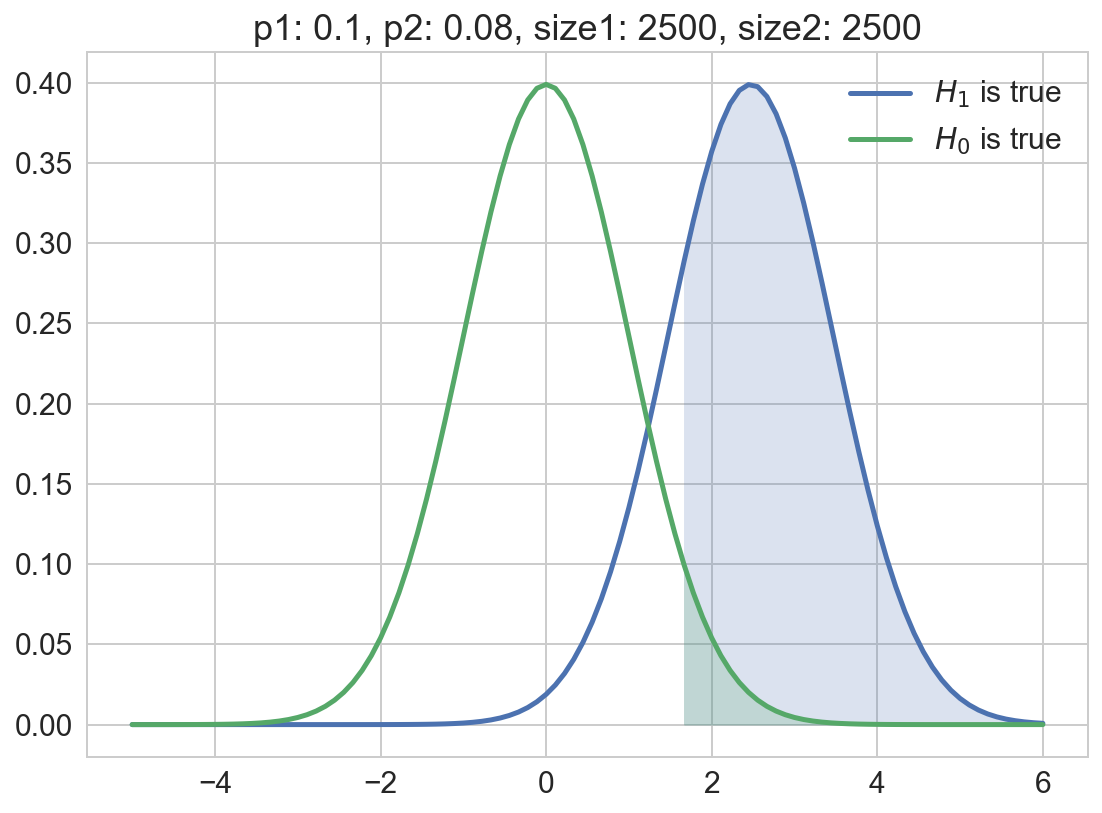

In [63]:
prob_b = 0.08
min_diff = 0.02
size_a = 2500
size_b = 2500

plot_power(min_diff, prob_b, size_a, size_b)

The shaded green area denotes the significance region, while the the shaded blue area denotes the power (note that it includes the shaded green area). Note that if we pick a smaller N, or a smaller probability difference between the control and experiment group, the power drops (the shaded blue area decreases), meaning that if there’s is in fact a change, there’s lesser percent chance that we’ll detect it:

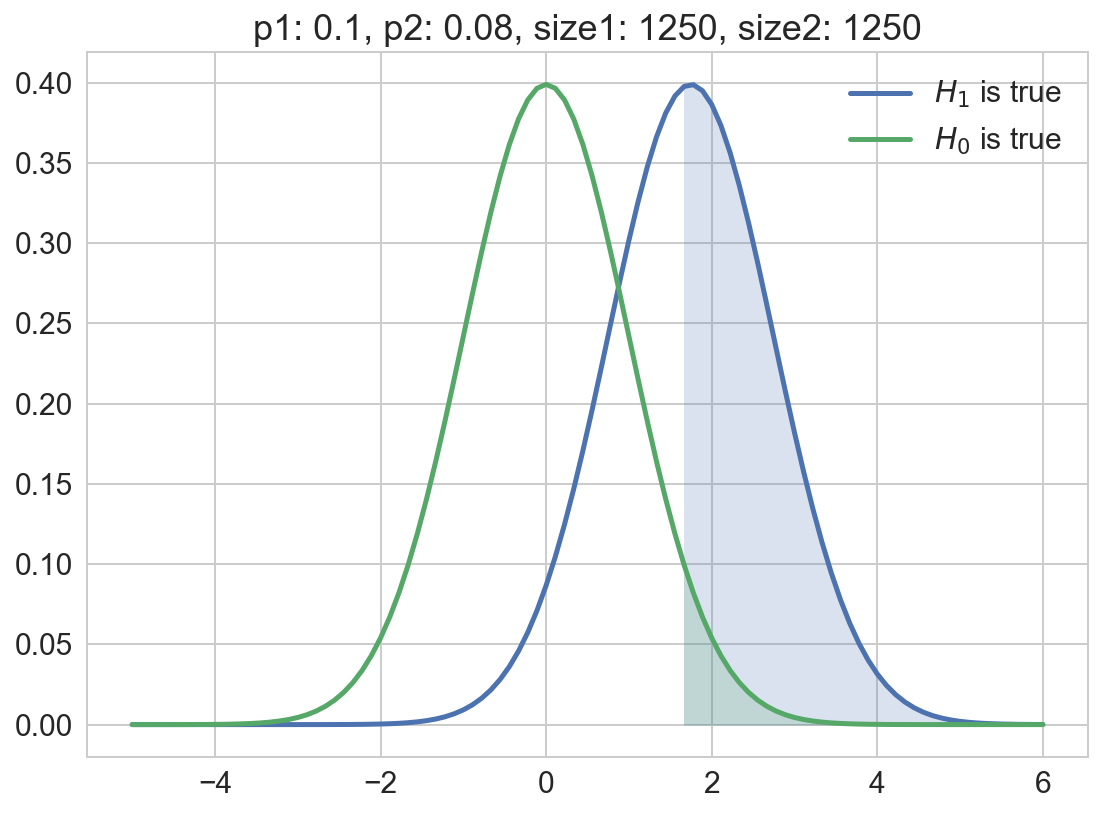

In [64]:
# smaller N
prob_b = 0.08
min_diff = 0.02
size_a = 1250
size_b = 1250

plot_power(min_diff, prob_b, size_a, size_b)

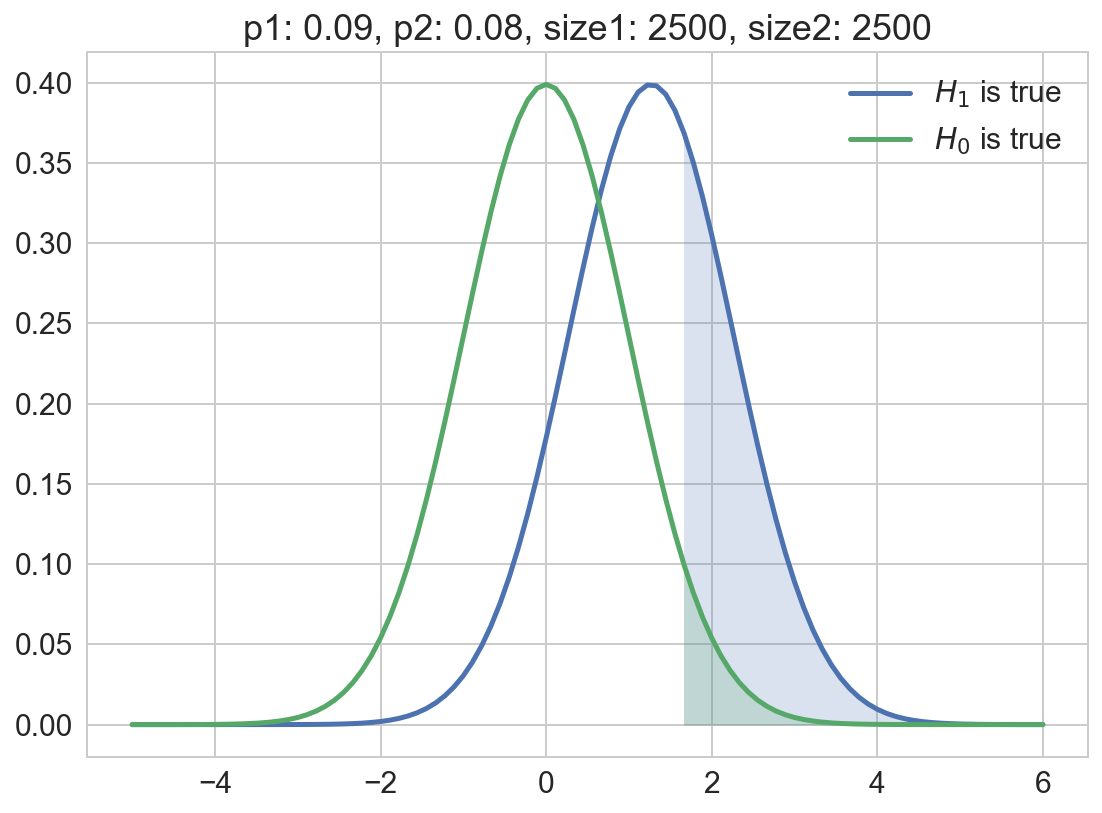

In [65]:
# smaller probability difference
prob_b = 0.08
min_diff = 0.01
size_a = 2500
size_b = 2500

plot_power(min_diff, prob_b, size_a, size_b)

In [ ]:
baseline =  0.1  # baseline conversion rate 
delta = 0.02 # minimum detectable boundary (practical significance boundary)
power = 0.8  # specificity, or true negative rate
significance = 0.05 # false positive rate


In [67]:
from statsmodels.stats.power import zt_ind_solve_power

zt_ind_solve_power(nobs1 = 2500, alpha = 0.05, power = 0.8, ratio = 1)

0.07924050194049188

## Alternative View of the Test Statistic


An appropriate hypothesis test here is Pearson's chi-squared test. There are two types of the chi-squared test, goodness of fit and test of independence, but it is the latter which is useful for the case in question. The reason as to why a test of “independence” is applicable becomes clear by converting the contingency table into a probability matrix by dividing each element by the grand total of frequencies:

In [15]:
cols = ['not_converted', 'converted']
data[cols] = data[cols] / data[cols].values.sum()
data

,version,not_converted,converted
0,A,0.4514,0.0486
1,B,0.4473,0.0527


We will denote $V$ as the version of the web page ($a$ or $b$) and $C$ as the conversion result, $f$ (false did not convert) or $t$ (true did in fact convert). The table that we computed above, which this the data that we observed can then be translated into this form:


| Version (V) | $f$ (false did not convert)  | $t$ (true did in fact convert) |
|:-----------:|:----------------------------:|:------------------------------:|
|    A        | $P(V = a, C = f)$            | $P(V = a, C = t)$              |
|    B        | $P(V = b, C = f)$            | $P(V = b, C = t)$              |


Now, our interest is whether the conversion $C$ depends on the page version $V$, and if it does, to learn which version converts better. In probability theory, the events $C$ and $V$ are said to be independent if the joint probability can be computed by $P(V, C) = P(V) \cdot P(C)$, where $P(V)$ and $P(C)$ are marginal probabilities of $V$ and $C$, respectively. It is straightforward to compute the marginal probabilities from row and column marginals:

$$P(V = a) = \frac{4514 + 486}{10000}  \hspace{1cm} P(V = b) = \frac{4473 + 527}{10000}$$
$$P(C = f) = \frac{4514 + 4473}{10000} \hspace{1cm} P(V = b) = \frac{486 + 527}{10000}$$

The null hypothesis is that $V$ and $C$ are independent, in which case the elements of the matrix, a.k.a the distribution that we're expecting is equivalent to:

| Version (V) | $f$ (false did not convert)  | $t$ (true did in fact convert) |
|:-----------:|:----------------------------:|:------------------------------:|
|    A        | $P(V = a)P(C = f)$           | $P(V = a)P(C = t)$             |
|    B        | $P(V = b)P(C = f)$           | $P(V = b)P(C = t)$             |


The conversion $C$ is said to be dependent on the version $V$ of the web site if this null hypothesis is rejected. Hence rejecting the null hypothesis means that one version is better at converting than the other. This is the reason why the test is on independence.

When dealing with counts and investigating how far the observed counts are from the expected counts, we use a test statistic called the **chi-square test**. The chi-squared test compares an observed distribution $O_{ij}$ to an expected distribution $E_{ij}$:

\begin{align}
\chi^2 = \sum_{i,j} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
\end{align}

It's calculated as the observed minus the expected for each cell squared divided by the expected counts, the division with the expected counts makes final result proportional to our expected frequency. After performing the computation for each cell, we want to sum this over all of the cells (levels of the categorical variable).

This $\chi^2$ probability distribution has only one parameter, the degrees of freedom. It influences the shape, the center and the spread of the chi-square distribution.

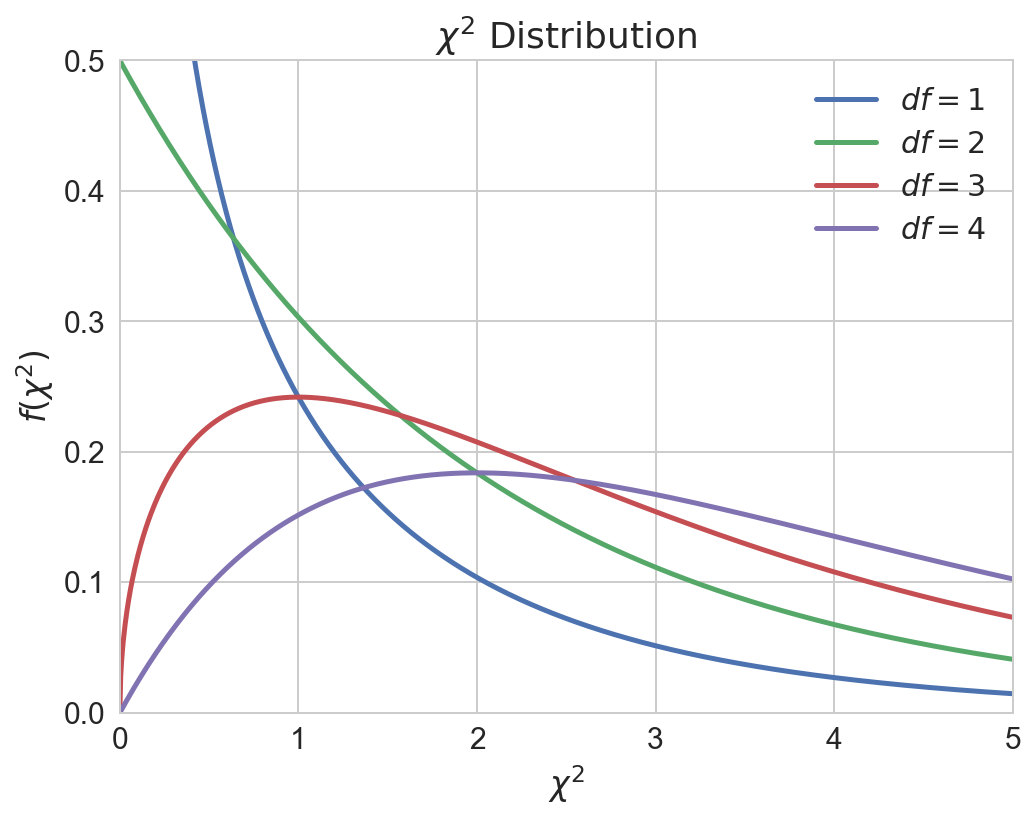

In [16]:
# chi square distribution with varying degrees of freedom
fig = plt.figure(figsize = (8, 6))
x = np.linspace(0, 5, 1000)
deg_of_freedom = [1, 2, 3, 4]
for df in deg_of_freedom:
    plt.plot(x, stats.chi2.pdf(x, df), label = '$df={}$'.format(df))

plt.xlim(0, 5)
plt.ylim(0, 0.5)
plt.xlabel('$\chi^2$')
plt.ylabel('$f(\chi^2)$')
plt.title('$\chi^2\ \mathrm{Distribution}$')
plt.legend()
plt.show()

chi-square distribution gives a way of measuring the difference between the frequencies we observe and the frequencies we expect. The smaller the value of $\chi^2$, the smaller the difference overall between the observed and expected frequencies. The way to compute the degree of freedom for the test of independence using a $r \times c$ contingency matrix is:

\begin{align}
df = (r - 1)(c - 1)
\end{align}

Where $r$ denotes the number of rows and $c$ denotes the number of columns. The rationale behind this calculation is because degrees of freedom is the number of expected frequencies we have to calculate independently after taking into account any restrictions. The restrictions come from the row and column sum constraints, but decreased by one because the last entry in the table/matrix is determined by either the row or column sum on that row/column.

Fortunately it is very straightforward to carry out this hypothesis testing using packages. All we need is to supply the function with a contingency matrix and it will return the $\chi^2$ statistic and the corresponding p-value:

In [17]:
# we can use the proportions_chisquare function,
# where we pass in the number of successes and
# the total number of trials/observation
count = np.array([486, 527])
nobs = np.array([5000, 5000])

# note that in this case (a two sample case with two sided
# alternative), the test produces the same value as porportions_ztest
# since the chi-square distribution is the square of a normal distribution
chisq, pvalue, table = proportions_chisquare(count, nobs)
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 1.8464754013996965, pvalue = 0.17419388311716985


In [18]:
# or the chi2_contingency function where we pass
# in the observed contingency table
observed = np.array([[4514,  486], [4473,  527]])

# more about the correction = False parameter later
result = stats.chi2_contingency(observed, correction = False)
chisq, pvalue = result[:2]
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 1.8464754013996965, pvalue = 0.17419388311716985


The result for our experiment has a  $\chi^2 = 1.74$ and $p = 0.185$. Since the p-value is greater than the standard threshold 0.05, we cannot reject the null hypothesis that the page version and the conversion is independent. Therefore the difference in the conversion rates is not statistically significant.

For a 2 x 2 contingency table, Yate’s chi-squared test is commonly used. This applies a correction of the form:

\begin{align}
\chi^2_{Yate's} = \sum_{i,j} \frac{(\big|O_{ij} - E_{ij}\big| - 0.5)^2}{E_{ij}}
\end{align}

to account for an error between the observed discrete distribution and the continuous chi-squared distribution (the step of -0.5 is often referred to as continuity correction).

In [19]:
# we can use the correcction form, by specifying
# correction = True
result = stats.chi2_contingency(observed, correction = True)
chisq, pvalue = result[:2]
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 1.7575018692680038, pvalue = 0.18493641552090323


Again, our pvalue is greater than the critical value, hence we simply would not reject the null hypothesis (that there is no relationship between the categorical variables).

> Side note: in practice, we want to make sure that each particular scenario or cell has at least five expected counts before employing the chi-square test.

# Reference

- [Notebook: Statistics for Hackers](http://nbviewer.jupyter.org/github/croach/statistics-for-hackers/blob/master/statistics-for-hackers.ipynb)
- [Blog: What Are P-Values?](https://prateekvjoshi.com/2013/12/07/what-are-p-values/)
- [Blog: Interpreting A/B Test using Python](http://okomestudio.net/biboroku/?p=2375)
- [Blog: Plot Chi-squared distribution with Python](http://knowledgetack.com/python/scipy/plot-chi-squared-distribution-with-python/)
- [Blog: A/B testing and Pearson's chi-squared test of independence](http://thestatsgeek.com/2013/07/22/ab-testing/)
- [Notes: Eberly College of Science STAT 414/415 Comparing Two Proportions](https://onlinecourses.science.psu.edu/stat414/node/268)